In [1]:
import pandas as pd
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import os
import subprocess
np.random.seed(42)

In [2]:
# Load the data
df = pd.read_csv("csv/ems_data.csv")
print("CSV Loaded, Dataset shape:", df.shape)

CSV Loaded, Dataset shape: (154, 6)


In [3]:
df

,species,emsConcentration,soakDuration,lowestTemp,highestTemp,result
0,Cotton - TM-1,1.50,180,20.0,32.0,1
1,Hemp - Lembang A,0.25,360,25.0,30.0,0
2,Cotton - TM-1,3.50,360,20.0,32.0,0
3,Hyoscyamus niger - Black Henbane,0.02,60,25.0,28.0,1
4,Sunflower - Helianthus annuus (BBS-1),1.00,480,22.0,25.0,0
...,...,...,...,...,...,...
149,Maize - Zea mays (B73),1.20,720,25.0,30.0,0
150,Hyoscyamus niger - Black Henbane,0.09,60,25.0,28.0,0
151,Hemp - Kumamoto,0.25,360,25.0,30.0,0
152,Chinese cabbage - Brassica rapa ssp. pekinensis,0.30,480,4.0,20.0,0


In [4]:
df.groupby('species').size().reset_index(name='sum')

,species,sum
0,Chinese cabbage - Brassica rapa ssp. pekinensis,5
1,Cotton - Luyanmian21,8
2,Cotton - TM-1,8
3,Fenugreek - Trigonella foenum-graecum,4
4,Fodder Barley - Hordeum vulgare,25
5,Hemp - Bandung A,8
6,Hemp - Indochina,8
7,Hemp - Kumamoto,8
8,Hemp - Lembang A,8
9,Hemp - Seiki Selskin,8


In [5]:
if not os.path.exists("pickles"):
    os.makedirs("pickles")

In [6]:
df['species']

0                                        Cotton - TM-1
1                                     Hemp - Lembang A
2                                        Cotton - TM-1
3                     Hyoscyamus niger - Black Henbane
4                Sunflower - Helianthus annuus (BBS-1)
                            ...                       
149                             Maize - Zea mays (B73)
150                   Hyoscyamus niger - Black Henbane
151                                    Hemp - Kumamoto
152    Chinese cabbage - Brassica rapa ssp. pekinensis
153                          Marigold - Tagetes erecta
Name: species, Length: 154, dtype: object

In [7]:
# Label encode the species column
le = LabelEncoder()
df['species'] = le.fit_transform(df['species'])

In [8]:
df['species']

0       2
1       8
2       2
3      10
4      16
       ..
149    12
150    10
151     7
152     0
153    13
Name: species, Length: 154, dtype: int64

In [9]:
# Save label encoder
with open('pickles/label_encoding.pkl', 'wb') as f:
    pickle.dump(le, f)

In [10]:
numerical_columns = ['soakDuration', 'lowestTemp', 'highestTemp']
df[numerical_columns]

,soakDuration,lowestTemp,highestTemp
0,180,20.0,32.0
1,360,25.0,30.0
2,360,20.0,32.0
3,60,25.0,28.0
4,480,22.0,25.0
...,...,...,...
149,720,25.0,30.0
150,60,25.0,28.0
151,360,25.0,30.0
152,480,4.0,20.0


In [11]:
# Scale numerical features
scaler = MinMaxScaler()
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])
df[numerical_columns]

,soakDuration,lowestTemp,highestTemp
0,0.060543,0.68,1.000000
1,0.123173,0.88,0.857143
2,0.123173,0.68,1.000000
3,0.018789,0.88,0.714286
4,0.164927,0.76,0.500000
...,...,...,...
149,0.248434,0.88,0.857143
150,0.018789,0.88,0.714286
151,0.123173,0.88,0.857143
152,0.164927,0.04,0.142857


In [12]:
# Save scaler
with open('pickles/scaler_encoding.pkl', 'wb') as f:
    pickle.dump(scaler, f)

In [13]:
df

,species,emsConcentration,soakDuration,lowestTemp,highestTemp,result
0,2,1.50,0.060543,0.68,1.000000,1
1,8,0.25,0.123173,0.88,0.857143,0
2,2,3.50,0.123173,0.68,1.000000,0
3,10,0.02,0.018789,0.88,0.714286,1
4,16,1.00,0.164927,0.76,0.500000,0
...,...,...,...,...,...,...
149,12,1.20,0.248434,0.88,0.857143,0
150,10,0.09,0.018789,0.88,0.714286,0
151,7,0.25,0.123173,0.88,0.857143,0
152,0,0.30,0.164927,0.04,0.142857,0


In [14]:
# Prepare features and target
X = df[['species', 'emsConcentration', 'soakDuration', 'lowestTemp', 'highestTemp']]
y = df['result']

In [15]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [16]:
# Initialize and train the model
rf_model = RandomForestClassifier(n_estimators=100, criterion='gini', random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [17]:
# Save the model
with open('pickles/ems_model.pkl', 'wb') as f:
    pickle.dump(rf_model, f)

In [18]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_val_score(rf_model, X, y, cv=kf, scoring='accuracy')

In [19]:
scores

array([0.8125    , 0.75      , 0.8125    , 0.8125    , 0.6       ,
       0.53333333, 0.8       , 0.73333333, 0.66666667, 0.66666667])

In [20]:
scores.mean()

np.float64(0.71875)

In [21]:
scores.std()

np.float64(0.09384254691296008)

In [22]:
print(f"Model Accuracy Score: {round(rf_model.score(X_test, y_test) * 100,1)}%")

Model Accuracy Score: 87.5%


In [23]:
y_pred = rf_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      1.00      0.93        13
           1       1.00      0.33      0.50         3

    accuracy                           0.88        16
   macro avg       0.93      0.67      0.71        16
weighted avg       0.89      0.88      0.85        16



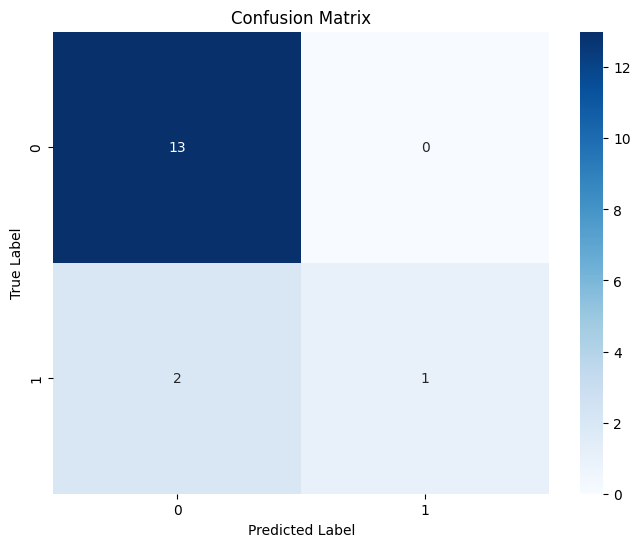

In [24]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [25]:
confusion_df = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])\
    .rename_axis(index={'Actual': 'Actual'}, columns={'Predicted': 'Predicted'})\
    .set_axis(['Fail rate', 'Success rate'], axis=0)\
    .set_axis(['Fail rate', 'Success rate'], axis=1)
print(confusion_df)

              Fail rate  Success rate
Fail rate            13             0
Success rate          2             1


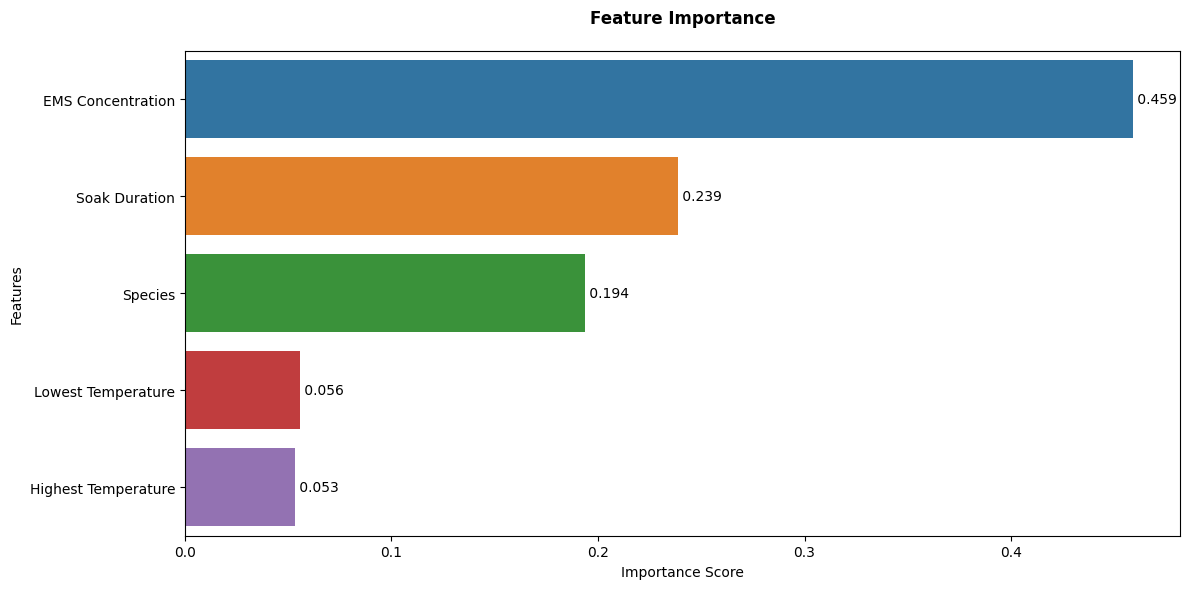

In [30]:
# Create and sort feature importance DataFrame
feature_names = ['Species', 'EMS Concentration', 'Soak Duration', 'Lowest Temperature', 'Highest Temperature']
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': rf_model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Create the plot
plt.figure(figsize=(12, 6))
ax = sns.barplot(
    x='importance', 
    y='feature', 
    hue='feature',  # Add hue parameter
    data=feature_importance, 
    legend=False    # Hide the legend
)

# Add value labels on the bars
for i, v in enumerate(feature_importance['importance']):
    # Format the value to show only 3 decimal places
    percentage = f'{v:.3f}'
    ax.text(v, i, f' {percentage}', va='center')

# Customize the plot
plt.title('Feature Importance', pad=20, fontsize=12, fontweight='bold')
plt.xlabel('Importance Score', fontsize=10)
plt.ylabel('Features', fontsize=10)

# Adjust layout to prevent text cutoff
plt.tight_layout()

# Show the plot
plt.show()

In [31]:
# Print tabular format for reference
print("\nFeature Importance Scores:")
print(feature_importance.to_string(index=False))


Feature Importance Scores:
            feature  importance
  EMS Concentration    0.458788
      Soak Duration    0.238507
            Species    0.193611
 Lowest Temperature    0.055741
Highest Temperature    0.053353
